In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from astropy.io import fits
import scipy
import pymaster as nmt

In [47]:
f0, f1 = '217', '217'
split0, split1 = '1', '2'

lmax = 2508
nside = 2048
lmax_beam = 3*nside # beam needs to extend to high enough ell for NaMaster

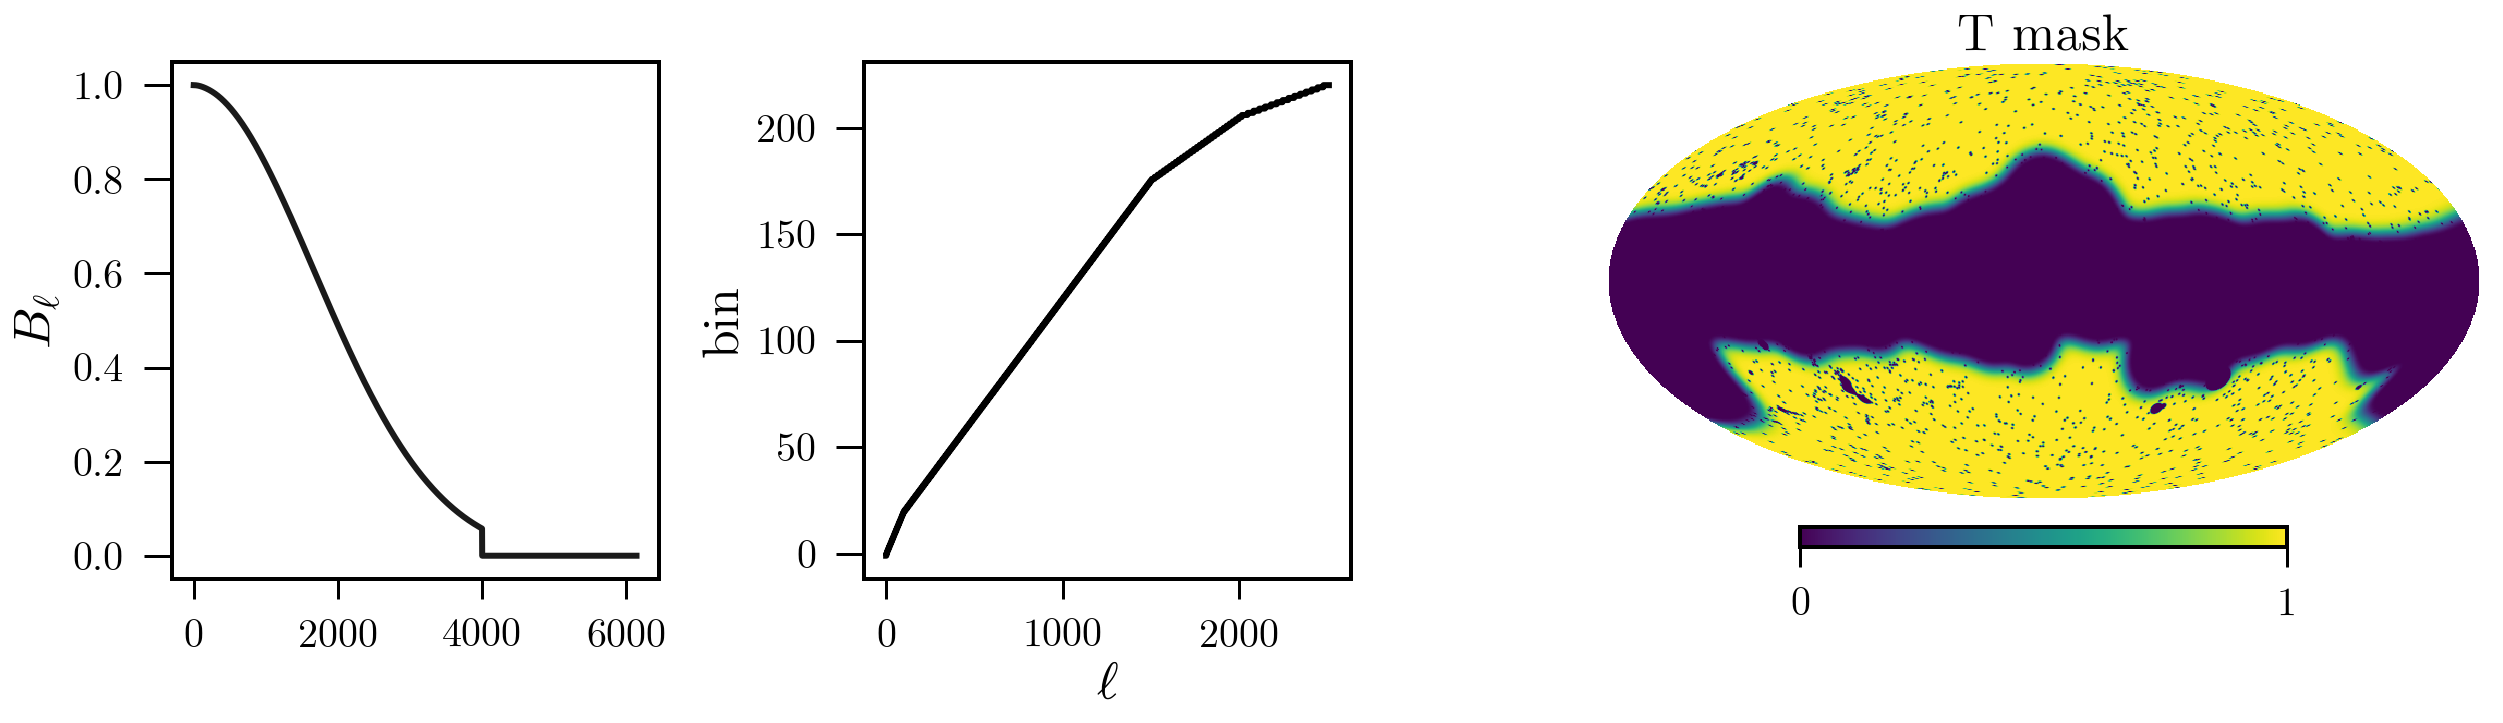

In [63]:
beam_filename = f'planck_beam/beam_likelihood_{f0}hm1x{f1}hm2.dat'
beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl
Bl = np.zeros(lmax_beam)
Bl[beam_ell.astype(int)] = beam

binleft, binright = np.genfromtxt('low_ell_binused.dat', 
                                  unpack=True, usecols=(0,1), dtype=((int), (int)))

binleft, binright = binleft, binright
ells = np.arange(lmax)
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
weights = np.array([1 for l in ells])
b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=False)
lb = b.get_effective_ells()

mask0t = hp.read_map(f'masks/COM_Mask_Likelihood-temperature-{f0}_2048_R2.00.fits', verbose=False)
mask0p = hp.read_map(f'masks/COM_Mask_Likelihood-polarization-{f0}_2048_R2.00.fits', verbose=False)
mask1t = hp.read_map(f'masks/COM_Mask_Likelihood-temperature-{f1}_2048_R2.00.fits', verbose=False)
mask1p = hp.read_map(f'masks/COM_Mask_Likelihood-polarization-{f1}_2048_R2.00.fits', verbose=False)


fig, ax = plt.subplots(1, 3, figsize=(18,5), gridspec_kw = {'width_ratios':[1, 1, 2]})
ax[0].plot( np.arange(lmax_beam), Bl)
ax[0].set_ylabel(r"$B_{\ell}$")
ax[1].plot(bpws, 'k-')
ax[1].set_ylabel('bin')
ax[1].set_xlabel(r'$\ell$')
fig.tight_layout()

plt.sca(ax[2])
hp.mollview(mask0t, hold=True, title='T mask')

In [49]:
m0_file = f'maps/PR3/frequencyMaps/HFI_SkyMap_{f0}_2048_R3.01_halfmission-{split0}.fits'
m1_file = f'maps/PR3/frequencyMaps/HFI_SkyMap_{f1}_2048_R3.01_halfmission-{split1}.fits'

# m0_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f0}_2048_R2.02_halfmission-{split0}.fits'
# m1_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f1}_2048_R2.02_halfmission-{split1}.fits'

# map0 = [hp.read_map(m0_file, field=0, verbose=False)] # I
# map1 = [hp.read_map(m1_file, field=0, verbose=False)] # I


map0 = [hp.read_map(m0_file, field=0, verbose=False), # I
        hp.read_map(m0_file, field=1, verbose=False), # Q
        hp.read_map(m0_file, field=2, verbose=False)] # U
map1 = [hp.read_map(m1_file, field=0, verbose=False), # I
        hp.read_map(m1_file, field=1, verbose=False), # Q
        hp.read_map(m1_file, field=2, verbose=False)] # U

In [50]:
badpix0 = [np.logical_or(m < -1e30, m > 0.002) for m in map0]
badpix1 = [np.logical_or(m < -1e30, m > 0.002) for m in map1]

map0 = [ (~bp).astype(float) * m for m, bp in zip(map0, badpix0) ]
map1 = [ (~bp).astype(float) * m for m, bp in zip(map1, badpix1) ]

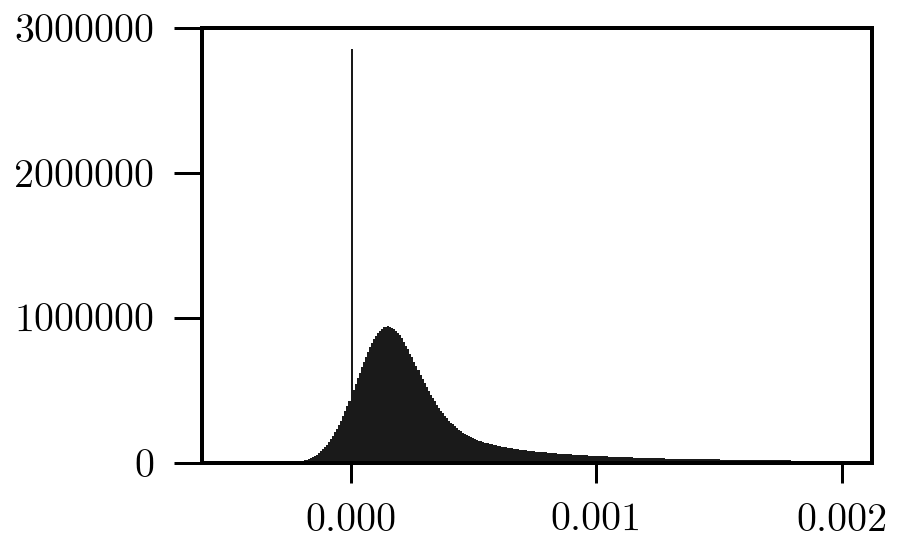

In [51]:
plt.hist(map0[0].flatten(), bins=300);

In [52]:
pixel_window = hp.sphtfunc.pixwin(nside, pol=False)[:len(Bl)]

In [53]:
niter = 0

f0t = nmt.NmtField(mask0t, [map0[0]], beam=(Bl*pixel_window), n_iter=niter)
f1t = nmt.NmtField(mask0t, [map1[0]], beam=(Bl*pixel_window), n_iter=niter)

f0p = nmt.NmtField(mask0p,[map0[1], map0[2]], beam=(Bl*pixel_window), n_iter=niter)
f1p = nmt.NmtField(mask1p,[map1[1], map1[2]], beam=(Bl*pixel_window), n_iter=niter)

w0=nmt.NmtWorkspace()
w0.compute_coupling_matrix(f0t,f1t, b, n_iter=niter)
w1=nmt.NmtWorkspace()
w1.compute_coupling_matrix(f0t,f1p, b, n_iter=niter)
w2=nmt.NmtWorkspace()
w2.compute_coupling_matrix(f0p,f1p, b, n_iter=niter)

def compute_master(f_a,f_b,wsp) :
    cl_coupled=nmt.compute_coupled_cell(f_a,f_b)
    cl_decoupled=wsp.decouple_cell(cl_coupled)
    return cl_decoupled


In [54]:
Cb_namaster={}
Cb_namaster['TT']=compute_master(f0t,f1t,w0)[0]
spin1=compute_master(f0t,f1p,w1)
Cb_namaster['TE']=spin1[0]
Cb_namaster['TB']=spin1[1]
Cb_namaster['ET']=Cb_namaster['TE']
Cb_namaster['BT']=Cb_namaster['TB']
spin2=compute_master(f0p,f1p,w2)
Cb_namaster['EE']=spin2[0]
Cb_namaster['EB']=spin2[1]
Cb_namaster['BE']=spin2[2]
Cb_namaster['BB']=spin2[3]

In [55]:
Cb_namaster2={}

spin1=compute_master(f1t,f0p,w1)
Cb_namaster2['TE']=spin1[0]
Cb_namaster2['TB']=spin1[1]
Cb_namaster2['ET']=Cb_namaster2['TE']
Cb_namaster2['BT']=Cb_namaster2['TB']


In [56]:
# # NaMaster-CAR only supports niter=0
# i0 = nmt.NmtField(mask0,[map0[0]], beam=(Bl*pixel_window), n_iter=3)
# i1 = nmt.NmtField(mask1,[map1[0]], beam=(Bl*pixel_window), n_iter=3)
# cl_00 = nmt.compute_full_master(i0,i1,b)

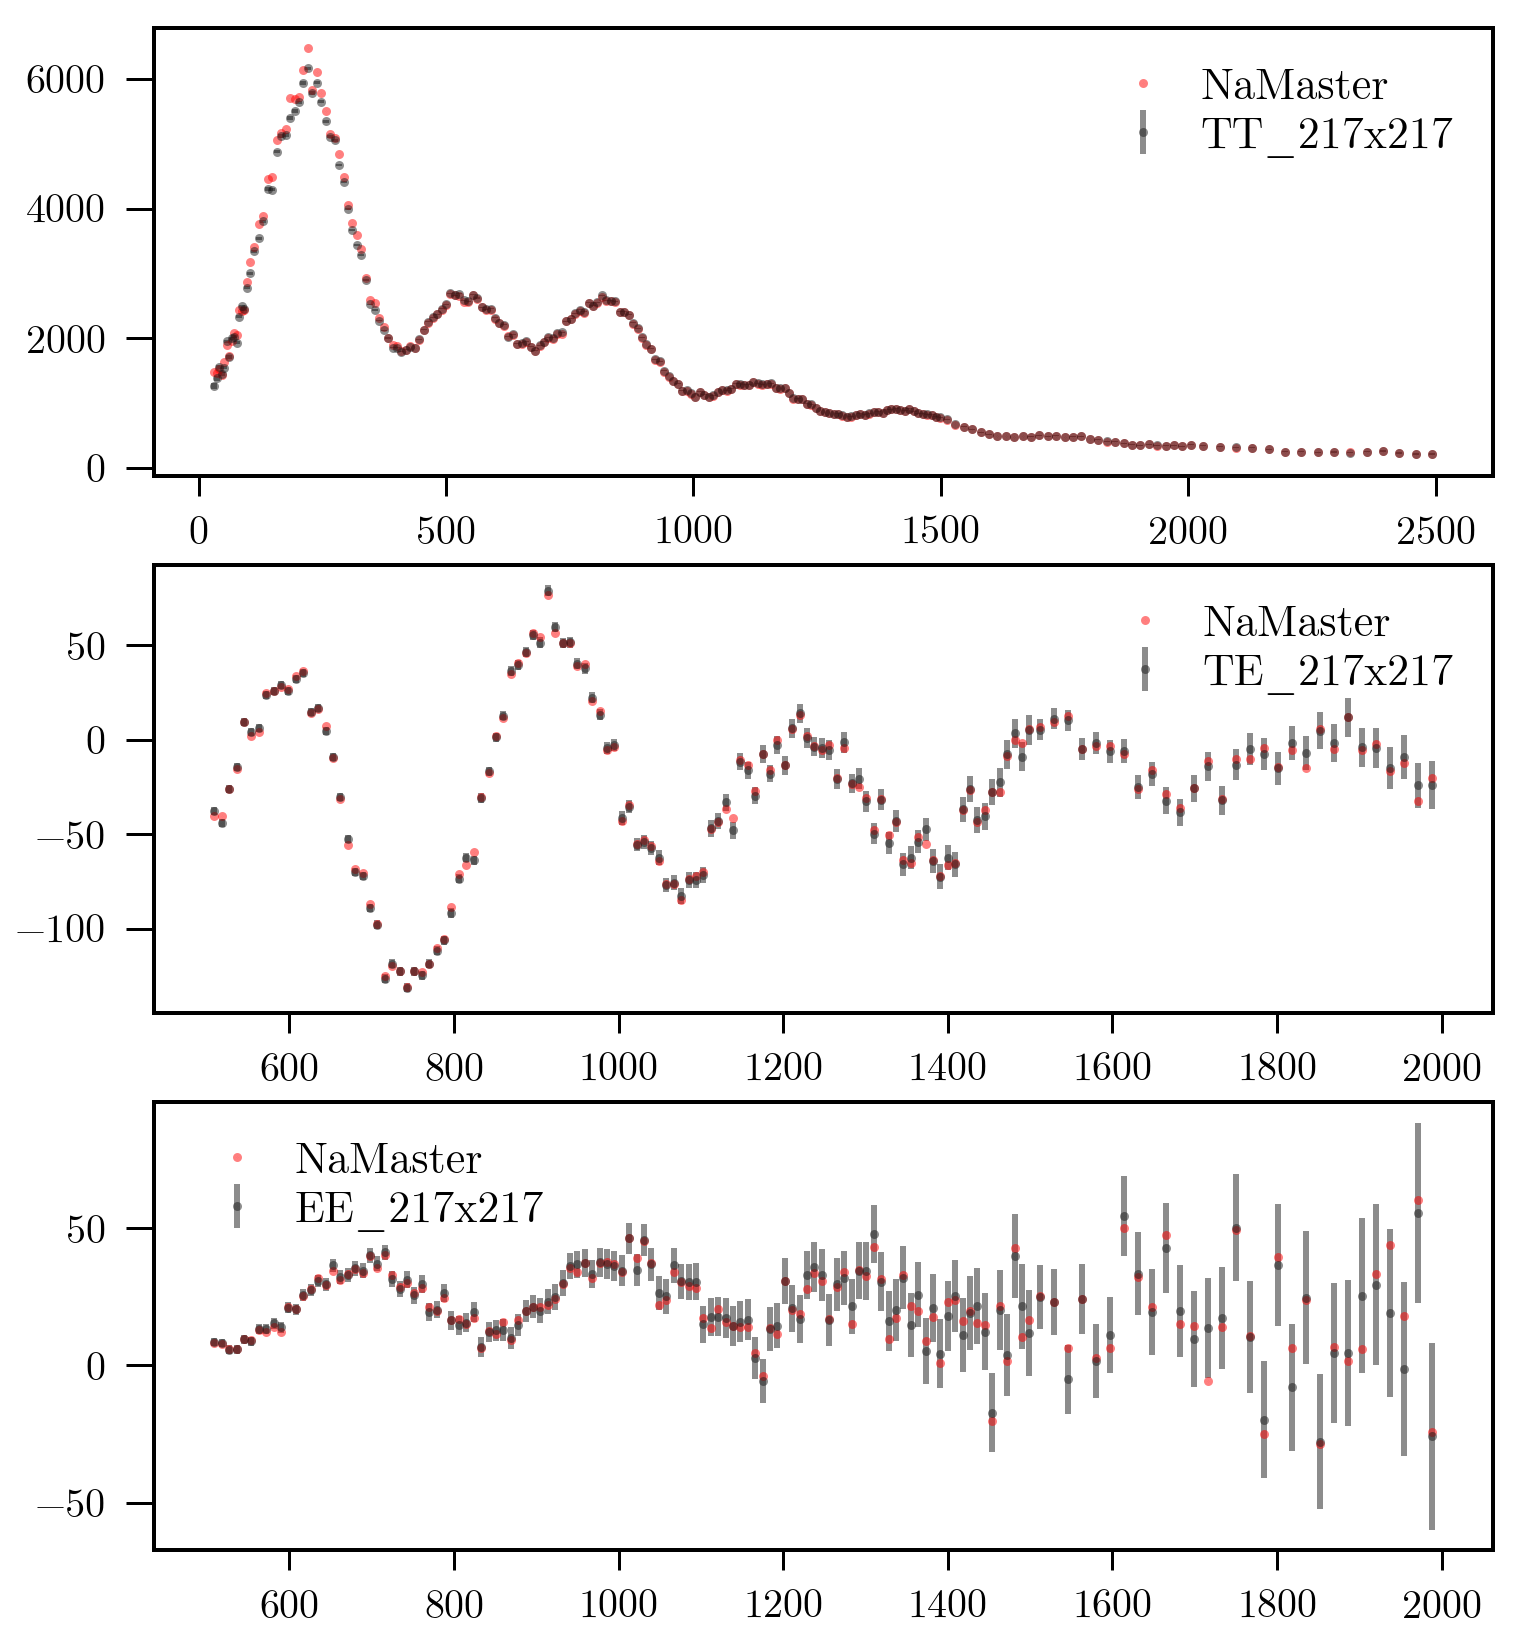

In [57]:
fig, axes = plt.subplots(3,1,figsize=(12,14))

for spec, ax in zip(['TT', 'TE', 'EE'], axes):
    lmin_,lmax_,l,cl,error=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{f0}x{f1}' + '.dat',unpack=True)
    dl_error = error*l*(l+1)/(2*np.pi)
    l_dl = lb[6:199+6]
    
    fp = Cb_namaster[spec]*1e12
    if spec == 'TE':
        fp = (Cb_namaster[spec] + Cb_namaster2[spec])*1e12 / 2
    dl = np.interp(x=l, xp=lb, fp=fp) *l*(l+1)/(2*np.pi)
    dl_ref = cl*l*(l+1)/(2*np.pi)
    ax.errorbar(l,dl_ref,error*l*(l+1)/(2*np.pi),fmt='.',label='%s'%f'{spec}_{f0}x{f1}', alpha=0.5)
    ax.plot(l, dl,'r.',label=r"NaMaster", alpha=0.5)

    ax.legend()
#     plt.yscale('log')

Text(0.5, 1.0, '217 x 217')

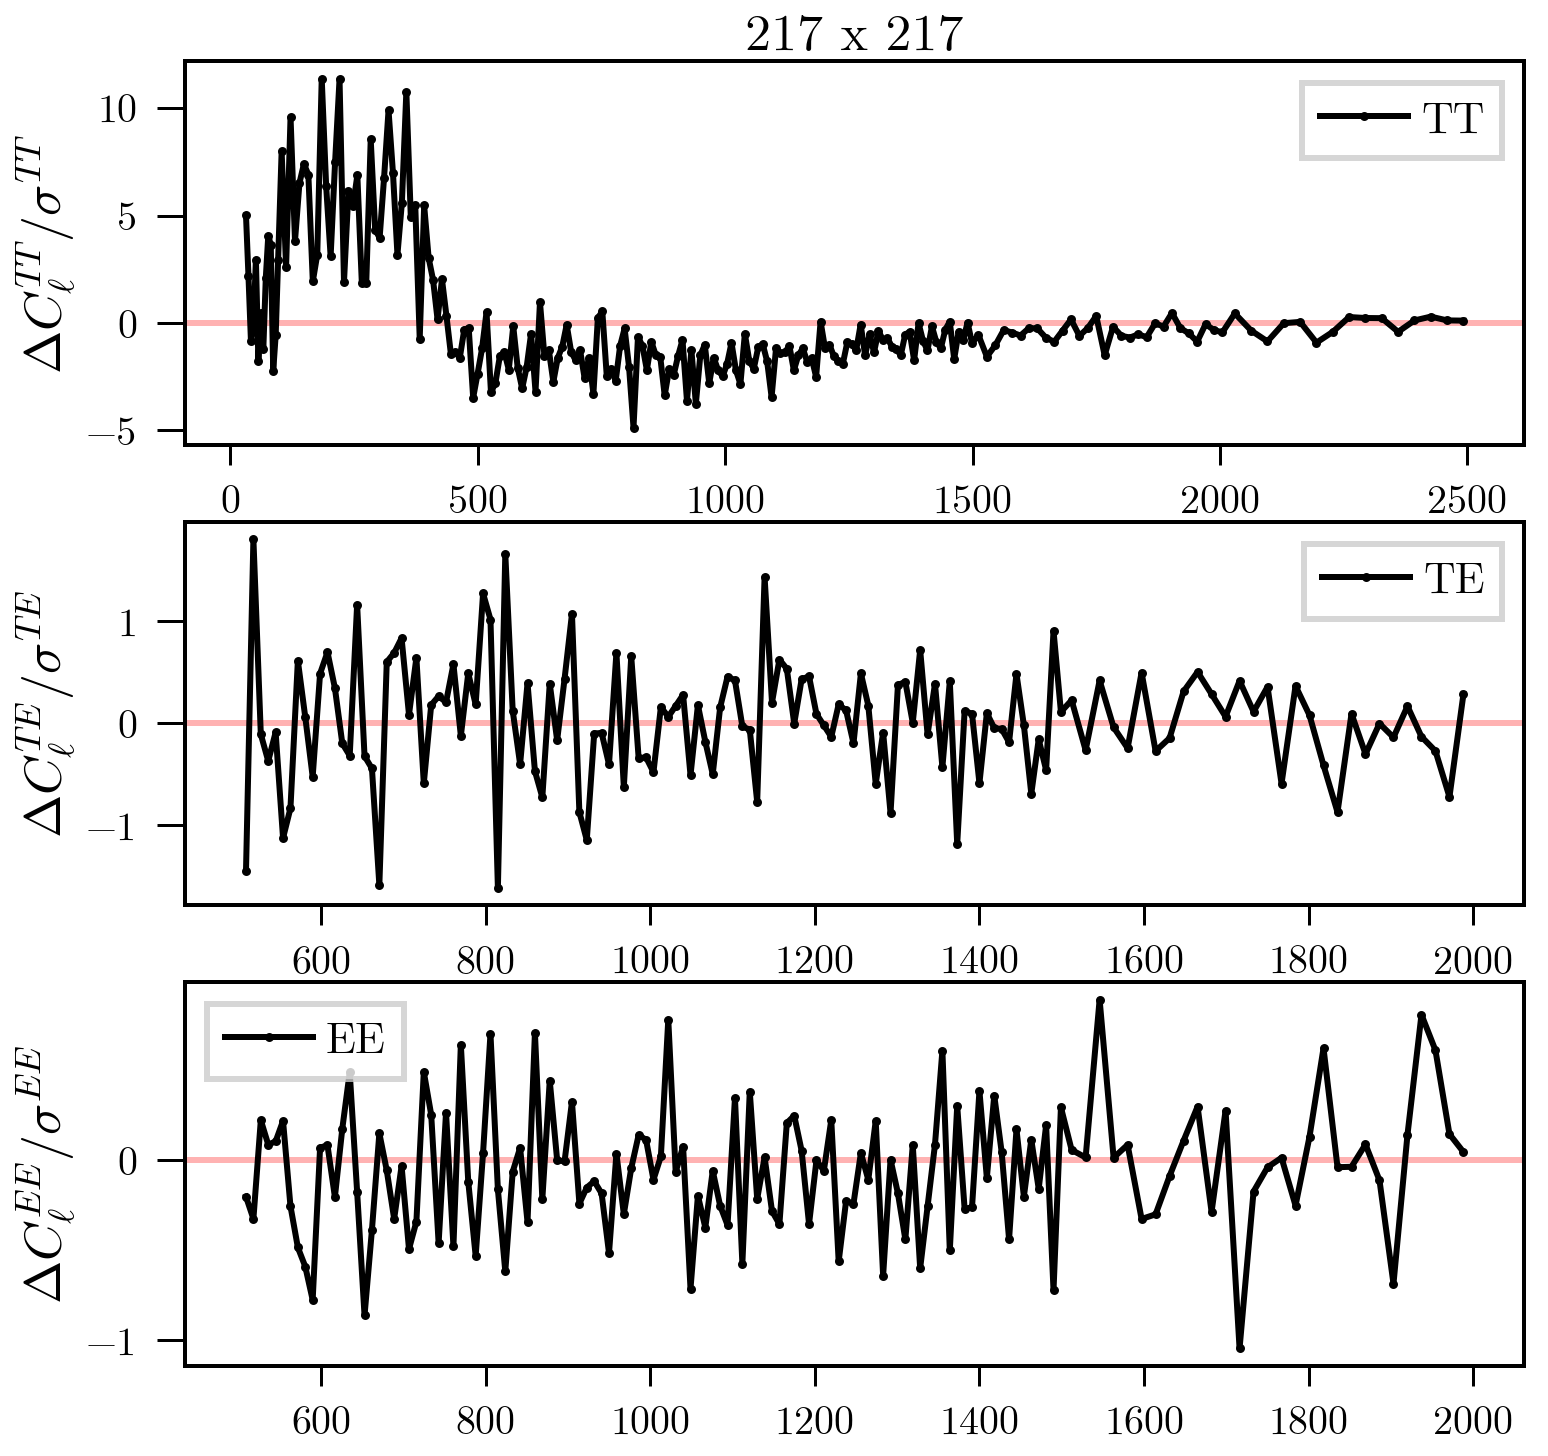

In [62]:
fig, axes = plt.subplots(3,1,figsize=(12,12))

for spec, ax in zip(['TT', 'TE', 'EE'], axes):
    lmin_,lmax_,l,cl,error=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{f0}x{f1}' + '.dat',unpack=True)
    dl_error = error*l*(l+1)/(2*np.pi)
    l_dl = lb[6:199+6]
    
    fp = Cb_namaster[spec]*1e12
    if spec == 'TE':
        fp = (Cb_namaster[spec] + Cb_namaster2[spec])*1e12 / 2
    dl = np.interp(x=l, xp=lb, fp=fp) *l*(l+1)/(2*np.pi)
    dl_ref = cl*l*(l+1)/(2*np.pi)
    
    ax.axhline(0, color='red', alpha=0.3)
    ax.plot( l,(dl - dl_ref) / (error*l*(l+1)/(2*np.pi)), 'k.-', label=spec)

    ax.legend(frameon=True, fancybox=False)
    ax.set_ylabel(r'$\Delta C_{\ell}^{' + spec + r'} / \sigma^{'  + spec + r'}$')
#     plt.yscale('log')

axes[0].set_title('217 x 217')